In [123]:
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
import cartopy
import os
import pandas as pd
import cftime
import datetime as dt
import tqdm
import netCDF4 as nc

import os 
import glob

In [140]:
in_file = '/mnt/drive3/atmos.static.nc'
ds = xr.open_dataset(in_file)
print(ds)
ds = ds.rename({'oro': 'hgt', 'landsea': 'lsm'})

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, phalf: 33)
Coordinates:
  * phalf      (phalf) float64 1.0 4.0 8.186 13.79 ... 970.8 982.6 992.2 1e+03
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
Dimensions without coordinates: bnds
Data variables:
    bk         (phalf) float32 ...
    pk         (phalf) float32 ...
    landsea    (lat, lon) float32 ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    oro        (lat, lon) float32 ...
    land_mask  (lat, lon) float32 ...
Attributes:
    filename:          atmos.static.nc
    title:             c96L32_am4g9_fullaero_MDTF
    associated_files:  area: 19970101.grid_spec.nc
    grid_type:         regular
    grid_tile:         N/A
    history:           fregrid --standard_dimension --input_mosaic C96_mosaic...
    code_version:      $Name: fre-nctools-bronx-10 $


In [141]:
ds.expand_dims(time=1)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, phalf: 33, time: 1)
Coordinates:
  * phalf      (phalf) float64 1.0 4.0 8.186 13.79 ... 970.8 982.6 992.2 1e+03
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
Dimensions without coordinates: bnds, time
Data variables:
    bk         (time, phalf) float32 0.0 0.0 0.0 0.0 ... 0.98142 0.99223 1.0
    pk         (time, phalf) float32 100.0 400.0 818.6021 ... 115.06646 0.0 0.0
    lsm        (time, lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    lat_bnds   (time, lat, bnds) float64 -90.0 -89.0 -89.0 ... 89.0 89.0 90.0
    lon_bnds   (time, lon, bnds) float64 0.0 1.25 1.25 2.5 ... 358.8 358.8 360.0
    hgt        (time, lat, lon) float32 2813.351 2815.518 2817.685 ... 0.0 0.0
    land_mask  (time, lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
Attributes:
    filename:          atmos.static.nc
    title:             c96L32_am4g9_fullaero_MDTF
    associated_files:  area: 19970101.grid_spec.nc
    grid_type:         regular
    grid_tile:         N/A
    history:           fregrid --standard_dimension --input_mosaic C96_mosaic...
    code_version:      $Name: fre-nctools-bronx-10 $

In [164]:
for var in ['lsm', 'hgt']:
    # var = 'hgt'
    out_var_map = {'hgt': 'orog', 'lsm': 'SFTLF'.lower()}
    out_var_ln = {'hgt': 'Surface Altitude', 'lsm': 'Land Area Fraction'}
    out_var_sn = {'hgt': 'custom_orog', 'lsm': 'custom_sftlf'}
    out_var_units = {'hgt': 'm', 'lsm': '1'}

    lon = ds.lon.values
    dlon = lon[1] - lon[0]
    lon = np.round(lon - dlon/2., decimals=2)

    lat = ds.lat.values
    dlat = lat[1] - lat[0]
    lat = np.round(lat - dlat/2., decimals=2)

    ds['lon'] = lon
    ds['lat'] = lat
    out_lon = lon
    out_lat = lat
    out_time = [12045.0]

    # out_var = np.empty((1, ds[var].shape[0], ds[var].shape[1]))
    # out_var[0, :, :] = ds[var].values

    out_var = ds[var].values

    out_file = f'/localdrive/drive10/jj/mdtf/inputdata/model/GFDL.EXP1.2PM.001/6hr/GFDL.EXP1.2PM.001.{out_var_map[var]}.6hr.nc'

    # out_ds = xr.Dataset({
    #         out_var_map[var]: (('time', 'lat', 'lon'), out_var), 
    #     }, 
    #     coords={
    #         'time': out_time, 
    #         'lat': out_lat, 
    #         'lon': out_lon,
    #     },
    #     )
    # # time attribs
    # out_ds.time.attrs['standard_name'] = 'time'
    # out_ds.time.attrs['long_name'] = 'time'
    # out_ds.time.attrs['units'] = 'days since 1975-01-01 00:00:00'
    # out_ds.time.attrs['calendar'] = 'noleap'
    # out_ds.time.attrs['bounds'] = 'time_bnds'

    out_ds = xr.Dataset({
            out_var_map[var]: (('lat', 'lon'), out_var), 
        }, 
        coords={
            'lat': out_lat, 
            'lon': out_lon,
        },
        )

    # lon attribs
    out_ds.lon.attrs['standard_name'] = 'longitude'
    out_ds.lon.attrs['long_name'] = 'longitude'
    out_ds.lon.attrs['units'] = 'degrees_east'

    # lat attribs
    out_ds.lat.attrs['standard_name'] = 'latitude'
    out_ds.lat.attrs['long_name'] = 'latitude'
    out_ds.lat.attrs['units'] = 'degrees_north'

    # slp attribs
    out_ds[out_var_map[var]].attrs['standard_name'] = out_var_sn[var]
    out_ds[out_var_map[var]].attrs['long_name'] = out_var_ln[var]
    out_ds[out_var_map[var]].attrs['units'] = out_var_units[var]

    # out_file = '/localdrive/drive10/jj/mdtf/inputdata/model/QBOi.EXP1.AMIP.001/topo.nc'
    out_ds.to_netcdf(out_file)

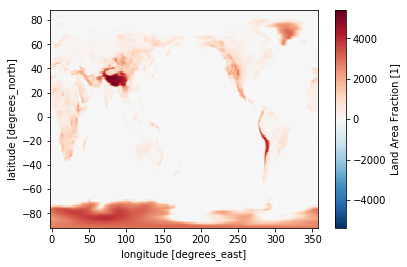

In [54]:
ds = xr.open_dataset('/localdrive/drive10/jj/mdtf/inputdata/model/GFDL.EXP1.2PM.001/6hr/GFDL.EXP1.2PM.001.SFTLF.6hr.nc')
ds.SFTLF.plot()
ds.close()